In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

df = pd.read_csv("C:\\Users\\lclai\\Desktop\\data_dementia\\clean\\pitt_clean.csv")
df = df[(df['label'] == 0) | (df['label'] == 1)]

df["sex"] = df["sex"].map({"M": 0, "F": 1})  
X_numeric = df[["age", "sex"]].values  

vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df["clean_transcripts"]).toarray()

X = np.hstack((X_numeric, X_text))
y = LabelEncoder().fit_transform(df["label"])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUC: 0.9184
AUC on test set: 1.0000
Accuracy on test set: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        60

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



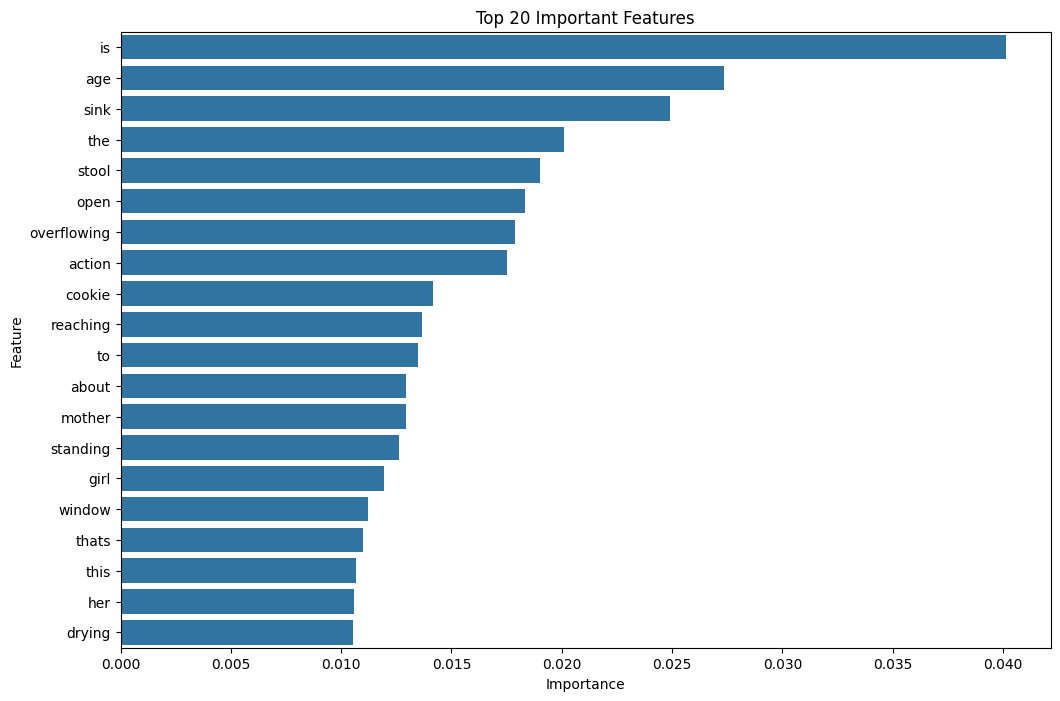

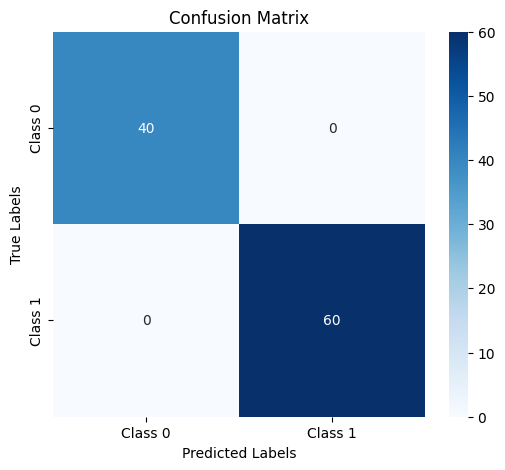

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
print(f"AUC on test set: {auc_score:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = best_clf.feature_importances_

feature_names = np.concatenate([["age", "sex"], vectorizer.get_feature_names_out()])
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  
plt.title('Top 20 Important Features')
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid = {
    'n_estimators': [100, 300],  
    'max_depth': [3, 6, 10],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1, 0.3]  
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_clf = grid_search.best_estimator_

y_pred = cross_val_predict(best_clf, X, y, cv=5)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")


Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation AUC: 0.8798


In [10]:
xgb_clf = XGBClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8,
    gamma=1, use_label_encoder=False, random_state=42
)

y_pred_proba_xgb = cross_val_predict(xgb_clf, X, y, cv=5, method="predict_proba")[:, 1]  

rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2,
    random_state=42
)

y_pred_proba_rf = cross_val_predict(rf_clf, X, y, cv=5, method="predict_proba")[:, 1]  

y_pred_proba_avg = (y_pred_proba_xgb + y_pred_proba_rf) / 2
y_pred_final = (y_pred_proba_avg >= 0.5).astype(int)  

auc_score = roc_auc_score(y, y_pred_proba_avg)

print(f"Mean AUC Score (XGBoost + RF): {auc_score:.4f}")


Mean AUC Score (XGBoost + RF): 0.8782


In [11]:
# softmax

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10], 
    'max_iter': [100, 200, 500] 
}

grid_search = GridSearchCV(softmax, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=5)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Best parameters: {'C': 10, 'max_iter': 100}
Best cross-validation AUC: 0.8913


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
